# MMN 13 - Linear Regression
### Roman Waitzman (313597270)

In this assignment I will implament a Linear Regression and attempt to classify the digits in the MNIST dataset, and compare it to the result of the Multi-Class Perceptron from MMN 11, and the Softmax Regression from MMN 12.

### Imports

In [ ]:
%pip install numpy pandas seaborn matplotlib scikit-learn tabulate

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import inf
from types import SimpleNamespace
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')
np.seterr(divide='ignore')

### Cleaning and re-arranging the dataset

The classes will be one-hot encoded as a vector of size 10 (the number of classes in the MNIST dataset) with every element in the vector being zero and the elementh in $ith$ place being 1, with $i$ corresponding to the numeric value of the class.
For example: $one\_hot('5') = (0,0,0,0,0,1,0,0,0,0)$

In [3]:
def one_hot_encoding(y):
  n_classes = int(y.to_numpy().max()) + 1
  y = y.astype(int)
  values = y.astype('int').to_list()
  one_hot_classes = np.eye(n_classes, dtype='int')
  return one_hot_classes[values]

I will first import the dataset, and clean the data up for the Linear Regression Model.

Each feature vector, which has 784 elements (a flattened 28*28 image) in the dataset will have a bias with the value 1 added to the beginning of the vector, meaning each feature vector is now of size 785.

In [4]:
# Access features (pixel values) and labels
X, y = mnist['data'], mnist['target']
classes = sorted(list(y.unique()))

# one hot encode labels
one_hot_y = one_hot_encoding(y)

# adding bias to dataset
X_biased = X.copy()
X_biased.insert(0, 'pixel0', 1)
X_proper = X_biased.to_numpy()

I will now use the train_test_split method supplied by sklearn to divide the dataset into training and testing sets.

The MNIST dataset has $70,000$ images, and as required by the outline of the assignment, the training set will be of size $60,000$ ($\frac{6}{7}th$ of the dataset), and the testing set will be of size $10,000$ ($\frac{1}{7}th$ of the dataset).

The sets will be stratified using the labels, to have a balanced representation of classes in our training and testing sets.


In [5]:
# change to constant integer for model testing and debug
random_state = None

# create test and train split
X_train, X_test, y_train, y_test = train_test_split(
  X_proper, one_hot_y, test_size=1/7,
  shuffle=True, stratify=one_hot_y,
  random_state=random_state
)

## Linear Regression
The Linear Regression attempts to linearly separate a group of points, this is going to be extended to a multi-class repgression for the purpose of the MNIST classification task.

#### Formulating the assaignment as a Linear Regression problem
Generally speaking Linear Regression will attempt to find the best hyperparameters such the they difine a hyperplane separating the samples according to some threshold (bias).

In our case, we have sample of a given class, for example '7', and all other classes (i.e. 'not-7'), we can attempt to find a hyperplane such that all '7's are on one side and all 'non-7's are on the other. So far we've fomrulated a Linear Regression interpretation fo a binary classification. In this case where we have multiple classes, similar to the logic of the previous assignments, we can simple attempt to find 10 different hyperplanes, each separationg between a class 'X' and a class 'not-X', using a weight **matrix** instead of a vector, such that each column is a linear separator for a specific class.

Let's formulate this notion.

#### Overview of the implemntation of the fitting algorithm:

##### **Mathematical Formulation**:
Let D be the length of each feature vector in the dataset $\textbf{X}$, C the number of classes and N the size of the dataset $\textbf{X}$.

Under the assumption that each **row** vector in $\textbf{X}$ is a feature vector, such that the size of $\textbf{X}$ is ${N\times D}$,
Let's first go over the hypotheses and loss for a single weight vector and a full dataset:

- $ h(\textbf{X}) = \textbf{X}*\underline{w} $
- $ \underline{y} =
\begin{pmatrix}
y_1 \\
y_2 \\
... \\
y_N
\end{pmatrix}
$
- $ E_{in}(\underline{w})=\frac{1}{N}\lVert e \rVert^2=\frac{1}{N}\rVert \underline{y} - \textbf{X}*\underline{w} \lVert ^2   $
- $∇E_{in}(\underline{w})=-\frac{2}{N}*\textbf{X}^T(\underline{y} - \textbf{X}\underline{w})
$

The new definitions for the multiclass linear regression with a weight a matrix $\textbf{W}_{D\times C}$, where each **column** $j$ will be the weight vector for the classification for class $j$:
- First of all one-hot representation will be used for the class labels, such that the vector $\underline{y}$ will become a matrix $\textbf{O}_{N\times C}$, where each **row** $i$ is the one-hot vector representation of the label of the feature vector in row $i$ in $\textbf{X}$.
- The hypothesis will simply be defined as $h(\textbf{X})=\textbf{X}*\textbf{W}
=\textbf{P}_{N\times C}$
- The matrix-form in-sample error will be the vector-form in-sample error, summed over each **column** vector $\underline{w}_j$ in $\textbf{W}$, and **column** vector $\underline{y}_j$ in $\textbf{O}$:

  $
  E_{in}(\textbf{W}) :=
  ∑_{j=1}^C\frac{1}{N}\rVert \underline{y}_j - \textbf{X}*\underline{w}_j \lVert ^2
  $
  
  The Frobenius Norm is defined as:
  
  $
  \lVert \textbf{A} \rVert_F
  = \sqrt{ ∑_{i=0}^N ∑_{j=0}^M \lvert a_{ij} \rvert ^2}
  $

  And so the matrix-form in-sample error is identical to a squared Frobenius Norm of $\textbf{O} - \textbf{P}$, normalized over the size of the dataset:

  $
  \frac{1}{N} \lVert \textbf{O} - \textbf{P} \rVert_F^2
  $
  
  $
  = \frac{1}{N} \lVert \textbf{O} - \textbf{X} * \textbf{W} \rVert_F^2
  $
  
  $
  = \frac{1}{N} ∑_{j=0}^C ∑_{i=0}^N \lvert y_{ij} - \underline{x}_i \underline{w}_j \rvert ^2
  $
  
  $
  = \frac{1}{N} ∑_{j=0}^C \rVert \underline{y}_j - \textbf{X}*\underline{w}_j \lVert ^2
  $
    
  $
  = ∑_{j=0}^C \frac{1}{N}  \rVert \underline{y}_j - \textbf{X}*\underline{w}_j \lVert ^2
  $
  
  $
  = E_{in}(\textbf{W})
  $

- Similarly, the gradient of the in-sample error defiend above will be:

 $
 ∇E_{in}(\textbf{W})
 $

 $
 := (∇E_{in}(\underline{w}_1), ... , ∇E_{in}(\underline{w}_C))
 $

 $
 = (-\frac{2}{N}*\textbf{X}^T(\underline{y}_1 - \textbf{X}\underline{w}_1), ... , -\frac{2}{N}*\textbf{X}^T(\underline{y}_C - \textbf{X}\underline{w}_C)
 $

 $
 = -\frac{2}{N}(\textbf{X}^T(\underline{y}_1 - \textbf{X}\underline{w}_1), ... , \textbf{X}^T(\underline{y}_C - \textbf{X}\underline{w}_C)
 $

 $
 = -\frac{2}{N}[(\textbf{X}^T\underline{y}_1 , ... , \textbf{X}^T\underline{y}_C)  - (\textbf{X}^T\textbf{X}\underline{w}_1, ... , \textbf{X}^T\textbf{X}\underline{w}_C)]
 $

 $
 = -\frac{2}{N}\textbf{X}^T[(\underline{y}_1 , ... , \underline{y}_C)  - (\textbf{X}\underline{w}_1, ... , \textbf{X}\underline{w}_C)]
 $

 $
 = -\frac{2}{N}\textbf{X}^T[(\underline{y}_1 , ... , \underline{y}_C)  - \textbf{X}(\underline{w}_1, ... , \underline{w}_C)]
 $

 $
 = -\frac{2}{N}\textbf{X}^T [\textbf{O} - \textbf{X}* \textbf{W}]
 $

 $
 = -\frac{2}{N}\textbf{X}^T [\textbf{O} - \textbf{P}]
 $

##### **Designing the fitting:**

The initial weight matrix will be $\textbf{W}^{\{0\}}_{D\times C}  =
\begin{pmatrix}
0.5 & 0.5 & ... & 0.5 \\
0   & 0   & ... & 0   \\
... & ... & ... & ... \\
0   & 0   & ... & 0
\end{pmatrix}
$.

For a dataset $\textbf{X}$, weight vector $\underline{w}$, and label vector $\underline{y}$ there is a closed form unique solution for optimal weights, which is:

$
\underline{w} = (\textbf{X}^T \textbf{X})^{-1} \textbf{X}^T \underline{y}
$

This only holds iff $\textbf{X}^T \textbf{X}$ is invertible (else the equation is undifined), and so before making an attempt to generalize the closed-form uniqe solution to fit a weight matrix $\textbf{W}$ representation, the invertiblity must be checked:

In [ ]:
print(f'The rank of X^T * X is: {np.linalg.matrix_rank(X_train.T @ X_train)}')

The rank of X^T * X is: 710


Which mean that $\textbf{X}^T \textbf{X}$ is not full rank, and so is not invertible.

As a result, this regression will implament Gradient Descent instead, and as such this method will also be extended.

The Gradient Descent is defined as:
$
\textbf{W}_{t+1}=\textbf{W}_{t}-\eta*∇E_{in}(\textbf{W}_{t})
$

And so plugging in the values computed above will get:
$
\textbf{W}_{t}-\eta*∇E_{in}(\textbf{W}_{t})
= \textbf{W}_{t}-\eta * -\frac{2}{N}\textbf{X}^T [\textbf{O} - \textbf{X}* \textbf{W}_t]
= \textbf{W}_{t} + \eta * \frac{2}{N}\textbf{X}^T [\textbf{O} - \textbf{X}* \textbf{W}_t]
= \textbf{W}_{t} + \eta * \frac{2}{N}\textbf{X}^T [\textbf{O} - \textbf{P}_t]
$.

Where $\eta$ is also widely called the "learning rate" and will control the tendency of the gradient descent.

One last caveat is the loss implamentation. The size of the values of the dataset will need to be stabilized or else the loss will be ineffectual in representing the progression of the GD, and as such the values in the dataset will be normalized at the beginning of the fitting to be between 0 and 1, this will be achieved by multiplying the entire dataset-matrix with the inverse of the largest element in the dataset.

And now the full logical & mathematical process has been derived.

#### Overview of the implementation of the scoring method
The prediction of the evaluation dataset will be performed as outlined above, for given weights achieved after performing fitting.

 To translate the probabilistic predictions into binary predictions,
 $p = argmax_{i\in\{0,...,9\}}(p_i) = argmax_{i\in\{0,...,9\}}([h(\underline{x})]_i)
 =
 argmax(\frac{1}{∑^C_{j=1}e^{\underline{w}_j^T*\underline{x}}}
 \begin{pmatrix}
 e^{\underline{w}_1^T*\underline{x}}\\
 e^{\underline{w}_2^T*\underline{x}}\\
 ...\\
 e^{\underline{w}_C^T*\underline{x}}
 \end{pmatrix}
 )
 =
 \frac{1}{∑^C_{j=1}e^{\underline{w}_j^T*\underline{x}}}
 argmax(
 \begin{pmatrix}
 e^{\underline{w}_1^T*\underline{x}}\\
 e^{\underline{w}_2^T*\underline{x}}\\
 ...\\
 e^{\underline{w}_C^T*\underline{x}}
 \end{pmatrix}
 )
 $

 will be used to chose which class is the best prediction for a given feature vector $\underline{x}$.

The scoring will return an assessment using the 'one-versus-all' strategy, where each class $i$ will be assessed in the following manner:
- $TP_i$ - number of instances of class $i$ predicted as class $i$
- $FN_i$ - number of instances of class $i$ predicted as some class other than $i$
- $FP_i$ - number of instances of all classes other than $i$ predicted as class $i$
- $TN_i$ - number of instances of all classes other than $i$ predicted as some class other than $i$ (mislabelling among these classes don't matter as long as class $i$ is not involved)

after that I will calculate the accuracy, sensitivity and selectivity and output all four calculations, using the equations given in the assignment:

- The Accuracy is defined as ACC=(TP+TN)/(TP+TN+FP+FN)
- The sensitivity (True positive rate) is defined as TPR = TP/(TP+FN)
- The selectivity (True negative rate) is defined as TNR = TN/(TN+FP)


#### Other useful information about the model implamentation
The model will also have the following option:
- A validation set & labels can be passed to calulate loss independantly for model analysis.
- The model has an optional cut off value, that will allow it to stop iteration early if difference between consecutive iterations falls beneath it.
- The model will have user friendly (albeit a bit a spammy) output messages during the fitting describing each epoch, that can be turned on and off if needed.

#### Class definition for Linear Regression

In [24]:
class LinearRegression:
  """
  A Linear regression model, generalized for multiclass
  binary-classification tasks.
  """

  def __init__(self):
    self._weights = None
    self._history = None

  # getters & setters #

  @property
  def history(self):
    return self._history

  # Fitting method and sub-methods #

  def fit(self, dataset, labels, epochs=20, lr=10 ** -5, validation=None,
          cut_off=None, verbose=True):
    """
    :param dataset: 2d array where each column is a feature vector.
    :param labels: 2d array of labels where each column is a one-hot
      representation of the label for the corresponding column in the
      'dataset'.
    :param epochs: number of iterations for the gradient descent algorithm.
      defualt is 20.
    :param lr: learning rate which acts as a scalar for gradient descent,
      used to avoid divergence on the one hand, and undershooting on the
      other.
    :param validation:
      a tuple which contains:
        [0]: a validaiton set that will be used to calulate a
        loss independant from the training set.
        [1]: corresponding one-hot labels.
      This set will have no influence over the training itself.
    :param cut_off: if a difference in loss in consecutive iterations falls
      beneath this threshold , the iteration will stop early.
      default is None.
    :param verbose: print out messages to user during fitting if True.
      default is True.
    """
    # create history DF if it doesn't exist
    if self._history is None:
      self._initialize_history(validation)

    # last_known_epoch used to keep correct epoch
    # enumeration in 'history' for multiple fits,
    # i.e. if fit is run more than once it should avoid the epoch
    # resetting in the middle of the history DataFrame
    last_known_epoch = self._history.iloc[-1]['epoch']

    # initial weight is as described in the exploration
    if self._weights is None:
      n_clas = labels.shape[1]
      n_featues = dataset.shape[1]
      weights = np.zeros((n_featues, n_clas), dtype='float')
      weights[0] = 0.5 * np.ones(n_clas)
    else:
      weights = self._weights

    # normalize dataset values to avoid overflow when exponentiating
    dataset = self._normalize(dataset)
    if validation is not None:
      val_set = self._normalize(validation[0])
      validation = (val_set, validation[1])

    # keep the previous loss of each iteration for cut off rate
    prev_loss = np.iinfo('int64').max

    # fit loop
    for epoch in range(1, epochs + 1):
      # create and evaluate prediction
      predictions = self._predict(dataset, weights)
      train_loss = self._loss(labels, predictions)

      # validation
      val_loss = None
      if validation is not None:
        val_predictions = self._predict(validation[0], weights)
        val_loss = self._loss(validation[1], val_predictions)

      # update history
      self._update_history(
        last_known_epoch, epoch, train_loss,
        val_loss=val_loss if validation is not None else None
        )

      # interactive user update
      if verbose:
        self._update_user(epoch, train_loss, val_loss)

      # cut-off rate for early exit
      loss_diff = np.abs(prev_loss - train_loss)
      if cut_off is not None and loss_diff < cut_off:
        break
      prev_loss = train_loss

      # new weights using GD
      d_weigths = self._gradient(dataset, predictions, labels)
      weights += -lr * d_weigths

    self._weights = weights

  @staticmethod
  def _normalize(dataset):
    # each value in the data set will be between 0 and 1
    return (1 / dataset.max()) * dataset

  @staticmethod
  def _predict(dataset, weights):
    # standard matrix product
    prediction = dataset @ weights
    return prediction

  @staticmethod
  def _loss(labels, predictions):
    # create diff matrix
    diff = labels - predictions

    # calculate the loss and normalize its size
    diff_norm = np.linalg.norm(diff, ord='fro') ** 2
    loss = (1 / len(diff)) * diff_norm
    return loss

  @staticmethod
  def _gradient(dataset, predictions, labels):
    # calculate diff matrix and product of dataset and diff
    diff = labels - predictions
    prod = dataset.T @ diff

    # gradient as computed in the deliberation
    gradient = - (2 / len(dataset)) * prod
    return gradient

  # fitting history & other methods #

  @staticmethod
  def _update_user(epoch, train_loss, val_loss=None):
    tl = np.abs(train_loss)
    vl = np.abs(val_loss)
    print(f"For epoch {epoch}: ")
    print(f"train loss is {tl:.4f}", end='')
    if val_loss is not None:
      print(f", validation loss is {vl:.4f}")
    else:
      print()

  def _initialize_history(self, validation):
    columns = ['epoch', 'train_loss']
    df_lsts = [[0, None]]

    if validation is not None:
      columns += ['validation_loss']
      df_lsts[0] += [None]

    self._history = pd.DataFrame(
      df_lsts,
      columns=columns)

  def _update_history(self, lk_epoch, epoch, train_loss,
                      val_loss=None):
    n_ind = len(self._history)
    history_epoch = lk_epoch + int(epoch)
    row = [history_epoch, train_loss]

    if val_loss is not None:
      row += [val_loss, ]

    self._history.loc[n_ind] = row

  # Predicting and Scoring methods and sub-methods #

  def predict(self, dataset):
    if self._weights is None:
      print(
        "Model is unfitted, please run 'fit' method on "
        "a training dataset first")
      return

    # predict dataset
    dataset = self._normalize(dataset)
    predictions = self._predict(dataset, self._weights)
    return predictions

  def score(self, predictions, labels):
    # get enumerated labels
    predictions_t = np.argmax(predictions, axis=1)
    labels_t = np.argmax(labels, axis=1)

    # create confusion matrix
    n_clas = self._weights.shape[1]
    conf_mat = np.zeros((n_clas, n_clas), dtype='int')
    for label, prediction in zip(labels_t, predictions_t):
      conf_mat[label][prediction] += 1

    # calculate evaluations
    acc_scr = self._aggregate_accuracy_score(conf_mat)

    # return evaluations
    retval = SimpleNamespace(confusion_matrix=conf_mat, accuracy_score=acc_scr)
    return retval

  @staticmethod
  def _aggregate_accuracy_score(confusion_matrix):
    # create assessment df
    headers = ['accuracy', 'sensitivity', 'selectivity']
    assessment = pd.DataFrame(columns=headers)

    # calcualte accuracy, sensitivity and selectivity using the method
    # described in the exploration
    n_clas = len(confusion_matrix)
    column_sums = np.sum(confusion_matrix, axis=0)
    row_sums = np.sum(confusion_matrix, axis=1)
    for i in range(n_clas):
      tp = confusion_matrix[i][i]
      tn = confusion_matrix.sum() - row_sums[i] - column_sums[i] + tp
      fp = column_sums[i] - tp
      fn = row_sums[i] - tp

      accuracy = np.round((tp + tn) / (tp + tn + fp + fn), 3)
      sensitivity = np.round(tp / (tp + fn), 3)
      selectivity = np.round(tn / (tn + fp), 3)
      assessment.loc[i] = [accuracy, sensitivity, selectivity]

    # calulate the average accuracy, sensitivity and selectivity of each
    # class in the model
    avg_accuracy = np.round(np.mean(assessment['accuracy']), 3)
    avg_sensitivity = np.round(np.mean(assessment['sensitivity']), 3)
    avg_selectivity = np.round(np.mean(assessment['selectivity']), 3)
    assessment.loc['avg'] = [avg_accuracy, avg_sensitivity, avg_selectivity]
    return assessment

#### Training the Linear Regression Model

After some expirementation, a learning rate of $10^{-2}$ was chosen, as a learning rate of $10^{-1}$ diverges almost immediately, and a learning rate of $10^{-3}$ converges very slowly.

After some attempts, the optimal number of epochs with the learning rate above for an an **average** accuracy and selectivity of **95%+** and sensitivity of **80%+** is about **50 epochs**. The runtime for 50 epochs was measured to be about 25 seconds on colab.

The tendency of the fitting algorithm plateaus quickly, for instance after 225 epochs the sensitivity stays below 85%.

To cut off early, set 'cut_off' to an acceptable loss ($E_{in}$) **difference between consecutive epochs**, to end the model early. To avoid excessive messaging, change "verbose" to False to silence model printouts.

In [37]:
lr = 10 ** -2
epochs = 50
cut_off = None
verbose = True

lnr = LinearRegression()
lnr.fit(
  X_train,
  y_train,
  epochs=epochs,
  lr=lr,
  validation=(X_test, y_test),
  cut_off=cut_off,
  verbose=verbose)

For epoch 1: 
train loss is 0.9961, validation loss is 0.9961
For epoch 2: 
train loss is 0.8710, validation loss is 0.8708
For epoch 3: 
train loss is 0.8310, validation loss is 0.8306
For epoch 4: 
train loss is 0.7995, validation loss is 0.7989
For epoch 5: 
train loss is 0.7719, validation loss is 0.7711
For epoch 6: 
train loss is 0.7473, validation loss is 0.7464
For epoch 7: 
train loss is 0.7254, validation loss is 0.7243
For epoch 8: 
train loss is 0.7059, validation loss is 0.7047
For epoch 9: 
train loss is 0.6884, validation loss is 0.6870
For epoch 10: 
train loss is 0.6727, validation loss is 0.6712
For epoch 11: 
train loss is 0.6585, validation loss is 0.6569
For epoch 12: 
train loss is 0.6457, validation loss is 0.6440
For epoch 13: 
train loss is 0.6341, validation loss is 0.6324
For epoch 14: 
train loss is 0.6236, validation loss is 0.6217
For epoch 15: 
train loss is 0.6139, validation loss is 0.6121
For epoch 16: 
train loss is 0.6052, validation loss is 0.6032
F

#### Assessing the Linear Regression model

In this graph I will plot the training loss and validation loss over each epoch in the model fitting process.

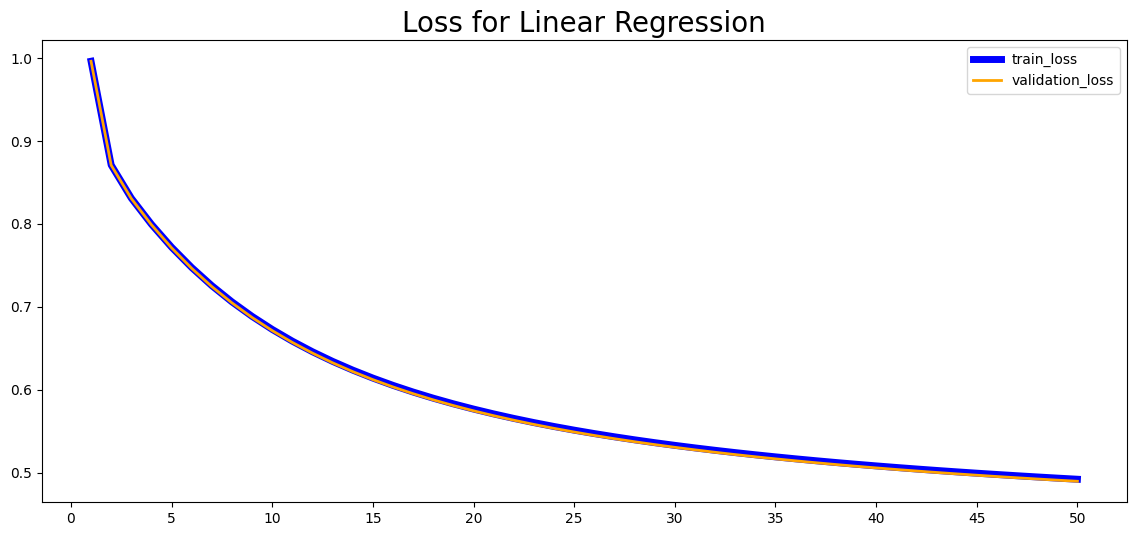

In [38]:
# fetch history
history = lnr.history.dropna()
t = history['epoch']
tl = history['train_loss']
vl = history['validation_loss']

# create graph
fig = plt.figure(figsize=(14, 6))
axs = fig.subplots()
font_size = 20

# plot loss
axs.plot(t, tl, 'b', lw=5, label=history.columns[1])
axs.plot(t, vl, 'orange', lw=2 ,label=history.columns[2])
axs.set_title('Loss for Linear Regression',  fontsize=font_size)
axs.legend()
plt.xticks(range(int(t.min())-1, int(t.max()+1), 5))

plt.show()

#### Scoring the Linear Regression model

Let's score the test set to see how the model will do.

In [39]:
# score test set
predictions = lnr.predict(X_test)
lnr_score = lnr.score(predictions, y_test)

Next, I will plot the confusion matrix given by the model's 'score' method over a seaborn heatmap:



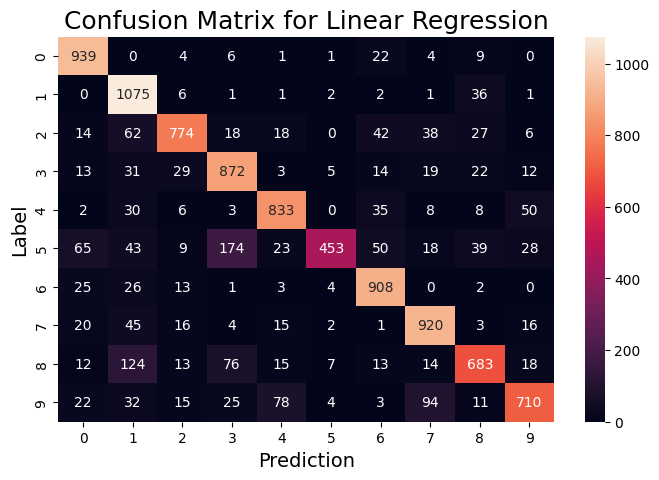

In [42]:
# fetch and arrange data to present in heatmap
header = lnr_score.accuracy_score.index[:-1]
confusion_matrix = lnr_score.confusion_matrix
heatmap_df = pd.DataFrame(confusion_matrix, index=header, columns=header)

# plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Linear Regression', fontsize=18)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Label', fontsize=14)

plt.show()

Finally, I will plot the model's assessment in table:

In [43]:
accuracy_score = lnr_score.accuracy_score
headers = accuracy_score.columns
table = tabulate(
  accuracy_score, headers=headers, tablefmt="grid")
print(table)

+-----+------------+---------------+---------------+
|     |   accuracy |   sensitivity |   selectivity |
+=====+============+===============+===============+
| 0   |      0.978 |         0.952 |         0.981 |
+-----+------------+---------------+---------------+
| 1   |      0.956 |         0.956 |         0.956 |
+-----+------------+---------------+---------------+
| 2   |      0.966 |         0.775 |         0.988 |
+-----+------------+---------------+---------------+
| 3   |      0.954 |         0.855 |         0.966 |
+-----+------------+---------------+---------------+
| 4   |      0.97  |         0.854 |         0.983 |
+-----+------------+---------------+---------------+
| 5   |      0.953 |         0.502 |         0.997 |
+-----+------------+---------------+---------------+
| 6   |      0.974 |         0.925 |         0.98  |
+-----+------------+---------------+---------------+
| 7   |      0.968 |         0.883 |         0.978 |
+-----+------------+---------------+----------

## Conclusion
On the one hand, Linear Regression performed about the same as the Multi-Class Perceptron with better benchmarking, as the accuracy, sensitivity and selectivity are pretty similar between both models, including particular failures (digit '5' in the Linear Regression vs digit '8' in the Multi-Class Perceptron), but the Linear Regression performed this in 50 epochs vs the 300+ epochs needed by the Perceptron, although on colab they performed in similar times, better hardware (GPUs) or under-the-hood implementation will allow Linear Regression to perform better than the Perceptron in real time.

On the other hand, Linear Regression performed relatively worse than The Softmax Regression model with a lower average accuracy, sensitivity and selectivity in over double the time (9 seconds** for Softmax Regression vs 25 seconds for Linear Regression) while staying in the same order of magnitude, and a much worse classification imbalance than the Softmax Regression.

As in the previous assignment, sensitivity the best assessor in this case for measuring the effective preformance of the model. Re-running the model for 200+ epochs, the average sensitivity will stay under **85%**, with individual classes (like 5 and 8) still lagging behind. This means that Linear Regression is supralinearly worse than Softmax Regression, which can achieve roughly **90%** sensitivity in around 100 epochs.

As such, although Linear Regression is a somewhat improvement over the Multi-Class Perceptron for MNIST digit classification, it still falls substantially behind Softmax Regression in this task. This makes some intuitive sense as Linear Regression isn't inherently designed for the task of multi-class binary classification, but for partitioning a space, which inherently makes it a less appropriate tool to tackle this specific issue when compared to the Softmax Regression, which is a probabalistic tool for binary classification. The stregths of Linear Regression meanwhile are two fold. The First is that if the dataset $\textbf{X}$ has that property that $\textbf{X}^T \textbf{X}$ is invertible we can calculate the optimal weights directly which allow a single-epoch fitting. The Second is that the mathematical definition of Linear Regression is differentiable and so we can implament Gradient Descent, which allows us a much faster (epoch-wise) convergence scheme than the PLA, which is designed specifically for binary classification.

-- Roman Waitzman - 313597270

** In MMN12 I used a weight matrix of "longdouble" instead of "float" which slowed down performance substantially for the Softmax Regression model, re-running with "float" achieves the runtime stated above.